# AirMSPI Space Carving
---

This notebook demonstrates Space-Carving [[1]] of the convex hull of a 3D cloud using AirMSPI data of a scene above the north Pacific ocean [[2]]. Out of the entire cloud field a single isolated cloud was cropped using `scripts/airmspi_crop_data.py`. The data was pre-processed using `notebooks/AirMSPI Preprocessing.ipynb` to compensate for cloud motion that occurs during acquisition. 

**Note that the compensation is mainly for across-track as the along-track motion can not be easily disambiguated from parallax.**

[1]: https://webee.technion.ac.il/~yoav/publications/Veikherman_Clouds_inthe_cloud.pdf

[2]: https://asdc.larc.nasa.gov/documents/airmspi/images/ELLIPSOID/AirMSPI_ER2_GRP_ELLIPSOID_20130206_202754Z_NorthPacificOcean-32N123W_000N_F01_V005.jpg

In [1]:
import numpy as np
import at3d
import matplotlib.pylab as plt
import xarray as xr
import glob
import netCDF4 as nc

%matplotlib notebook

In [43]:
def project_to_altitude(theta, phi, alt):
    tan_theta = np.tan(np.deg2rad(theta)) * alt
    delta_x = tan_theta * np.cos(np.deg2rad(phi))
    delta_y = tan_theta * np.sin(np.deg2rad(phi))
    return delta_x, delta_y

def generate_sensor(data, wavelength, stokes='I'):
    """
    Azimuth is measured from North and X is pointing East (ENU coordinates).
    https://asdc.larc.nasa.gov/documents/airmspi/guide/AirMSPI_Cloud_Droplet_ATBD.20180117.pdf
    """
    zenith = data['View_zenith']
    azimuth = 90 - data['View_azimuth']
    x, y = np.meshgrid(data['XDim'], data['YDim'])
    dx, dy = at3d.preprocessing.project_to_altitude(zenith, azimuth, toa)
    x = (x + dx).values.ravel() - x0
    y = (y + dy).values.ravel() - y0
    z = np.full_like(x, fill_value=toa)
    mu = np.cos(np.deg2rad(zenith.values.ravel()))
    phi = np.deg2rad(azimuth.values.ravel())
    sensor = at3d.sensor.make_sensor_dataset(
        x[np.isfinite(x)], y[np.isfinite(y)], z[np.isfinite(x)], mu[np.isfinite(mu)], 
        phi[np.isfinite(phi)], stokes, wavelength, fill_ray_variables=True)
    return sensor

In [44]:
datapath = '../data/airmspi/26-May-2021-18:56:49_Preprocessed*'
files = glob.glob(datapath)

toa = 10.0         # [km]
wavelength = 0.935 # [micron]
stokes = 'I'    

oblique_tresh = 8.0e-3
radiance_tresh = 5.e-3

# Translate coordinates to start at (0,0)
x0, y0 = -1, -1.35
sensor_list = []
for file in files:
    data = xr.load_dataset(file, group='radiance').sel(band='{}nm'.format(int(1e3*wavelength)))
    sensor = generate_sensor(data, wavelength)
    
    # Generate cloud masks
    pixels = data.I.values.ravel()
    pixels = pixels[np.isfinite(pixels)]
    weights = np.zeros(sensor.sizes['nrays'])

    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    threshold = oblique_tresh if data.view_angle in ['661F', '661A'] else radiance_tresh
    ray_mask_pixel[np.where(pixels > threshold)] = 1
    sensor['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    
    sensor_list.append(sensor)

In [45]:
rte_grid = at3d.grid.make_grid(0.05, 45, 0.05, 59, np.linspace(0.9,2.0,23))
space_carver = at3d.space_carve.SpaceCarver(rte_grid)
volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0))

<IPython.core.display.Javascript object>


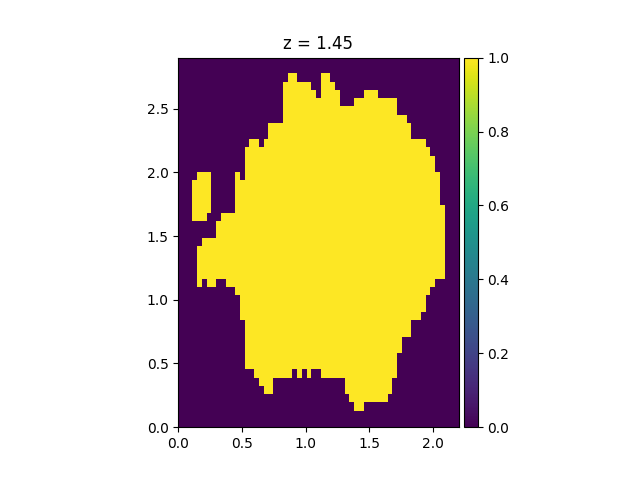

interactive(children=(IntSlider(value=11, description='frame', max=22), Output()), _dom_classes=('widget-inter…

In [46]:
volume.mask.visualization.slider(dim='z')

In [59]:
"""
Save data for tomographic recovery
"""
wavelength = 0.865

stokes = ['I', 'Q', 'U']
filename = '../data/airmspi/26-May-2021-18:56:49_Spacecarved_Volume.nc'
save_file = nc.Dataset(filename, 'w')
save_file.close()

radiance_tresh = [1e-2, 1.5e-2, 9e-3, 8e-3, 1.8e-2, 1e-2, 9e-3, 8e-3, 1.8e-2]
for file, threshold in zip(files, radiance_tresh):
    data = xr.load_dataset(file, group='polarization').sel(band='{}nm'.format(int(1e3*wavelength)))
    sensor = generate_sensor(data, wavelength, stokes)
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    ray_mask_pixel[data.I.values[np.isfinite(data.I.values)] > threshold] = 1
    sensor['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor['I'] = ('npixels', data.I.values[np.isfinite(data.I.values)])
    sensor['Q'] = ('npixels', data.Q_meridian.values[np.isfinite(data.Q_meridian.values)])
    sensor['U'] = ('npixels', -data.U_meridian.values[np.isfinite(data.U_meridian.values)])
    sensor.to_netcdf(filename, 'a', group='sensors/{}'.format(data.view_angle.values[0]))
   
solarmu = np.cos(np.deg2rad(data.Sun_zenith + 180.0)).mean()
solar_azimuth = (90.0 - data.Sun_azimuth).mean() + 360.0
source = at3d.source.solar(wavelength, solarmu, solar_azimuth)
source.to_netcdf(filename, 'a', group='source')

volume.attrs.update(agreement='(0.0, 1.0)')
volume.to_netcdf(filename, 'a', group='grid')